## I. Import Libraries and Data

In [1]:
import re
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tpot import TPOTClassifier
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import coo_matrix, hstack
from scipy.sparse import csr_matrix, hstack

from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

#readability
import textstat

#sytax
import nltk

## II. Define Functions

## A. Cleaning and Read Functions

In [2]:
def cleanArticle(string):
    strip_special_chars = re.compile("[^A-Za-z0-9' ]+")
    string = string.lower().replace("<br />", " ")
    return re.sub(strip_special_chars, "", string.lower())

def read_perez_dataset(dataset_name):
    
    def remove_numbers(in_str):
        return re.sub(r'[0-9]+', '', in_str)
    
    print("Reading dataset")
    result_data_list = []
    data_dir = PEREZ_DATASET_PATH
    for news_type in ['fake', 'legit']:
        folder = '%s/%s/%s' % (data_dir, dataset_name, news_type)
        for fname in os.listdir(folder):
            result_data = {}
            result_data['dataset_name'] = dataset_name
            result_data['news_type'] = news_type
            if news_type == 'fake':
                result_data['is_fake'] = 1
            else:
                result_data['is_fake'] = 0
            if dataset_name == 'fakeNewsDataset':
                result_data['news_category'] = remove_numbers(fname.split('.')[0])
            result_data['file_name'] = fname
            filepath = os.path.join(folder, fname)
            with open(filepath, 'r', encoding="utf8") as f:
                file_data = f.read().split('\n')
                # Some articles don't have a headline, but only article body.
                if len(file_data) > 1:
                    news_content_data = ' '.join(file_data[2:])
                    result_data['news_headline'] = file_data[0]
                else:
                    news_content_data = file_data[0]
                    result_data['news_headline'] = ''
                result_data['news_content'] = news_content_data
                result_data['news_all'] = ' '.join(file_data[0:])
                result_data_list.append(result_data)
                
    df = pd.DataFrame(result_data_list)
    
    df['news_all_clean'] = df['news_all'].apply(lambda a: cleanArticle(a))
    
    X_train, X_test, y_train, y_test = train_test_split(df.drop(['is_fake',
                                                               'news_type','file_name'],
                                                               axis = 1), 
                                                        df['is_fake'], 
                                                        test_size=.2, random_state=RANDOM_SEED)
    
    print("Finished reading dataset")
    return df, X_train.reset_index(drop = True), y_train.reset_index(drop = True), X_test.reset_index(drop = True), y_test.reset_index(drop = True)

def model_report(title, y_test, predictions, predictions_proba):

    """
    Output: Classification report, confusion matrix, and ROC curve
    """
    print(title)
    print("---------")
    print(classification_report(y_test, predictions))

    cm = metrics.confusion_matrix(y_test, predictions)
    plt.figure(figsize=(3,3))
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy: {0}'.format(round(metrics.accuracy_score(y_test, predictions),2))
    plt.title(all_sample_title, size = 15)
    plt.show()
    
    fpr, tpr, threshold = metrics.roc_curve(y_test, predictions_proba)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## B. Linguistic-based feature creators

### 1. Ngram & Punctuation

In [3]:
def pad_punct(s):
    """
    Add padding around specified punctuation.
    """
    s = re.sub('([.,!?():])', r' \1 ', s)
    s = re.sub('\s{2,}', ' ', s)
    return s
def tfidf_vectorizer_custom(train, test, ngram_range):
    """
    Create a tfidf vectorized set for train and test data that counts punctuation.
    Ngram range = (1,3)
    """
    train = train.apply(pad_punct)
    test = test.apply(pad_punct)
    vect = TfidfVectorizer(token_pattern=r"(?u)\b\w\w+\b|!|\.|,|\)|\(|\:|\?|\"|\'", #pattern keep punctuation in vectorizer
                          ngram_range = ngram_range).fit(train)
    vocab = vect.vocabulary_.keys()
    vocab = sorted(vocab, key=len)
    print("Traing data info:")
    print('- Vocabulary len:', len(vect.get_feature_names()))
    print('- Longest phrase:', max(vect.vocabulary_, key=len))
    print('- Smallest 10 phrases:', vocab[0:10])
    print('- Sample of features:',np.array(vect.get_feature_names()))
    train_vectorized = vect.transform(train)
    test_vectorized = vect.transform(test)
    return train_vectorized, test_vectorized

### 2. Psycholinguistic features

In [4]:
def LIWC_counter(df1, df_LIWC, train_LIWC):
    """
    Inputs: - Data set with field: news_all_clean
            - Preprocessed LIWC lookup table
    Ouput:  - Data set with 73 additional fields for LIWC count results (normalized over string word count)
    """
    df = df1.copy()
    LIWC_vars = train_LIWC.drop('Word', axis = 1).columns.values
    for i in LIWC_vars:
        df[i] = 0
        words = df_LIWC[df_LIWC[i] == 1]['Word']
        for a in words:
            df[i] = (df[i] + 
                df.news_all_clean.str.count(str(" " + a + " "))  + #free floating word
                df.news_all_clean.str.count(str("^" + a + " ")) +  #start word
                df.news_all_clean.str.count(str(" " + a + "$")))   #end word
        df[i] = df[i] / df.news_all_clean.str.count(" ") #normalize over word count
    return df

### 3. Readability

In [5]:
def readability_enricher(df1):
    """
    Input: a dataframe with column "news_all" to be analyzed for a variety of readbility metrics.
    Output: the inputted dataframe, enriched with all readbility metrics (there are a total of 10, one of which is categorical).
    """
    df = df1.copy()
    df["flesch_reading_ease"]=0.0
    df["smog_index"]=0.0
    df["flesch_kincaid_grade"]=0.0
    df["coleman_liau_index"]=0.0
    df["automated_readability_index"]=0.0
    df["dale_chall_readability_score"]=0.0
    df["difficult_words"]=0.0
    df["linsear_write_formula"]=0.0
    df["gunning_fog"]=0.0
    df["text_standard"]=0.0

    for i in range(df.shape[0]):
        text = df['news_all'].iloc[i]
        df.loc[i,("flesch_reading_ease")]= textstat.flesch_reading_ease(text)
        df.loc[i,("smog_index")]= textstat.smog_index(text)
        df.loc[i,("flesch_kincaid_grade")]= textstat.flesch_kincaid_grade(text)
        df.loc[i,("coleman_liau_index")]= textstat.coleman_liau_index(text)
        df.loc[i,("automated_readability_index")]= textstat.automated_readability_index(text)
        df.loc[i,("dale_chall_readability_score")]= textstat.dale_chall_readability_score(text)
        df.loc[i,("difficult_words")]= textstat.difficult_words(text)
        df.loc[i,("linsear_write_formula")]= textstat.linsear_write_formula(text)
        df.loc[i,("gunning_fog")]= textstat.gunning_fog(text)
        df.loc[i,("text_standard")]= textstat.text_standard(text)
    
    return df

### 4. Syntax

In [6]:
def POS_tagger(text):
    """
    Tag POS using nltk. Return a single "sentence" with the POS of each word treated like a "word."
    """
    tokens = nltk.word_tokenize(text)
    text = nltk.Text(tokens)
    tags = nltk.pos_tag(text)
    return " ".join([i[1] for i in tags])

def POS_enricher(df1):
    """
    Input: a dataframe with column "news_headline" and "news_content".
    Output: the inputted dataframe, with the columns "news_headline_POS" and "news_content_POS" created which are a single sentence with the 
    POS of each word represented as word in that same position.
    """
    df = df1.copy()
    df["news_headline_POS"]=""
    df["news_content_POS"]=""
    
    for i in range(df.shape[0]):
        text_headline = cleanArticle(POS_tagger(df['news_headline'].apply(lambda a: cleanArticle(a)).iloc[i]))
        text_content = cleanArticle(POS_tagger(df['news_content'].apply(lambda a: cleanArticle(a)).iloc[i]))
        
        df.loc[i,("news_headline_POS")]= text_headline
        df.loc[i,("news_content_POS")]= text_content
    
    return df

## III. Read in Data, Define Test/Train Set

In [7]:
RANDOM_SEED = 42
PEREZ_DATASET_PATH = "../data/fakeNewsDatasets_Perez-Rosas2018"
np.random.seed(RANDOM_SEED)
perez_full, train_data, train_labels, test_data, test_labels = read_perez_dataset('celebrityDataset')
train_data.head()

Reading dataset
Finished reading dataset


,dataset_name,news_all,news_content,news_headline,news_all_clean
0,celebrityDataset,Malia Obama Has Barack And Michelle Worried – ...,"Malia Obama, 18, is adjusting to her new life ...",Malia Obama Has Barack And Michelle Worried – ...,malia obama has barack and michelle worried c...
1,celebrityDataset,Scarlett Johansson's New Man Has Confirmed The...,From the editors of HelloGiggles There’s been...,Scarlett Johansson's New Man Has Confirmed The...,scarlett johansson's new man has confirmed the...
2,celebrityDataset,Tyga To Reveal The Ugly Truth About Kylie Jenn...,Tyga and Kylie Jenner have made it to Splitsvi...,Tyga To Reveal The Ugly Truth About Kylie Jenn...,tyga to reveal the ugly truth about kylie jenn...
3,celebrityDataset,How Janet Jackson lost 70 pounds The 51-year-...,The 51-year-old new mom is sporting a sleek ph...,How Janet Jackson lost 70 pounds,how janet jackson lost 70 pounds the 51yearol...
4,celebrityDataset,Halle Berry Jokes About Pregnancy Rumors UPDA...,UPDATE: Halle Berry joked about the pregnancy ...,Halle Berry Jokes About Pregnancy Rumors,halle berry jokes about pregnancy rumors upda...


## IV. Run Train/Test Set through LIWC Rented License

We rented the LIWC dataset (for 30 days), as seen here: https://store5.esellerate.net/store/checkout/CustomLayout.aspx?s=STR6622550055&pc=&page=OnePageMoreInfo.htm&SkuRefNum=SKU48070077205

We downloaded the software, outputted the train/test set, ran the train/test set through the LIWC software, and uploaded the LIWC results.
The software marks words to 73 LIWC categories in a binary format (with an 'X')

In [13]:
train_data['news_all'].to_csv("train_data_news_all_forLIWC_celeb.txt")
test_data['news_all'].to_csv("test_data_news_all_forLIWC_celeb.txt")
train_LIWC = pd.read_csv(
    "LIWC2015 Results (train_data_news_all_forLIWC_celeb).csv").fillna(0).drop('Unnamed: 74', axis = 1).replace('X',1)
test_LIWC = pd.read_csv(
    "LIWC2015 Results (test_data_news_all_forLIWC_celeb).csv").fillna(0).drop('Unnamed: 74', axis = 1).replace('X',1)

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (7,8,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [14]:
train_LIWC.head()

,Word,function,pronoun,ppron,i,we,you,shehe,they,ipron,...,home,money,relig,death,informal,swear,netspeak,assent,nonflu,filler
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,malia,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,obama,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,has,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,barack,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
test_LIWC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6945 entries, 0 to 6944
Data columns (total 74 columns):
Word            6945 non-null object
function        6945 non-null int64
pronoun         6945 non-null int64
ppron           6945 non-null int64
i               6945 non-null int64
we              6945 non-null int64
you             6945 non-null int64
shehe           6945 non-null int64
they            6945 non-null int64
ipron           6945 non-null int64
article         6945 non-null int64
prep            6945 non-null int64
auxverb         6945 non-null int64
adverb          6945 non-null int64
conj            6945 non-null int64
negate          6945 non-null int64
verb            6945 non-null int64
adj             6945 non-null int64
compare         6945 non-null int64
interrog        6945 non-null int64
number          6945 non-null int64
quant           6945 non-null int64
affect          6945 non-null int64
posemo          6945 non-null int64
negemo          6945 non-nul

## IV. Quick Look at Data

In [16]:
train_data['news_all_clean'].iloc[1]

"scarlett johansson's new man has confirmed they are dating  from the editors of hellogiggles  theres been word that saturday night lives weekend update host colin jost is dating scarlett johansson while hollywood dating rumors often turn out to be true we kinda assumed this cool couple might have been a passing phase and wed never hear of it again  turns out jost and johansson are so serious that johansson was actually going to accompany jost as his date to the emmys tbh had they stepped out as a couple we would have died  shes wonderful shes working so otherwise shed be here colin told entertainment tonight on the emmys red carpet shes pretty coolits hard to have a lot of complaints shes pretty awesome  jost explained that they met on the set of snl  the first time she hosted was the first year i was a writer on the show colin said so weve kind of known each other since thenshes the best im very happy im very lucky  snl was nominated for a slew of cast performance awards plus outstan

In [17]:
print("full perez size: ", perez_full.shape)
print("train size: ",train_labels.shape)

full perez size:  (500, 8)
train size:  (400,)


In [19]:
#sns.catplot(x="news_category", kind = "count", hue="is_fake", data=perez_full)
#plt.show()

In [14]:
#perez_full.groupby(['news_category','is_fake']).size()

news_category  is_fake
biz            0          40
               1          40
edu            0          40
               1          40
entmt          0          40
               1          40
polit          0          40
               1          40
sports         0          40
               1          40
tech           0          40
               1          40
dtype: int64

## V. Create Feature-Enriched Training/Testing Datasets

## A. Implement Feature Creating Functions

#### 1. Ngram & Punctuation

In [20]:
train_data_vectorized, test_data_vectorized = tfidf_vectorizer_custom(
    train_data['news_all'], test_data['news_all'], ngram_range = (1,2))

Traing data info:
- Vocabulary len: 98647
- Longest phrase: 3333333333333333333333333333333333333 triplets
- Smallest 10 phrases: ['?', ',', '.', ':', "'", '(', ')', '!', '"', 'in']
- Sample of features: ['!' '! !' '! "' ... 'zwang ,' 'über' 'über talented']


#### 2. Psycholinguistic features

In [21]:
train_data_LIWC = LIWC_counter(train_data, train_LIWC, train_LIWC)
test_data_LIWC = LIWC_counter(test_data, test_LIWC, train_LIWC)

### 3. Readability

In [22]:
train_data_readability = readability_enricher(train_data)
test_data_readability = readability_enricher(test_data)

### 4. Syntax

In [23]:
train_POS_init = POS_enricher(train_data)
test_POS_init = POS_enricher(test_data)

POS_headline_train_data_vectorized, POS_headline_test_data_vectorized = tfidf_vectorizer_custom(
    train_POS_init['news_headline_POS'], test_POS_init['news_headline_POS'], ngram_range = (1,3))

POS_content_train_data_vectorized, POS_content_test_data_vectorized = tfidf_vectorizer_custom(
    train_POS_init['news_content_POS'], test_POS_init['news_content_POS'], ngram_range = (1,3))

train_POS = hstack([POS_headline_train_data_vectorized, POS_content_train_data_vectorized])
test_POS = hstack([POS_headline_test_data_vectorized, POS_content_test_data_vectorized])

Traing data info:
- Vocabulary len: 1581
- Longest phrase: vbz vbn prp
- Smallest 10 phrases: ["'", 'nn', 'cc', 'md', 'vb', 'rb', 'in', 'jj', 'to', 'dt']
- Sample of features: ["'" "' '" "' ' cc" ... 'wrb prp vbz' 'wrb to' 'wrb to vb']
Traing data info:
- Vocabulary len: 7852
- Longest phrase: vbz prp nns
- Smallest 10 phrases: ["'", 'cd', 'to', 'jj', 'nn', 'in', 'dt', 'cc', 'rb', 'vb']
- Sample of features: ["'" "' '" "' ' cc" ... 'wrb vbz vbn' 'wrb wrb' 'wrb wrb prp']


### B. Unify All Features in Single Dataset

In [45]:
def add_feature(sparse, df_to_sparse, df_ignore):
    """
    Returns sparse feature matrix with added feature.
    """
    return hstack([coo_matrix(df_to_sparse.drop(df_ignore.columns.values, axis = 1)),sparse])

def add_categorical_feature(train_sparse, test_sparse, train_data, test_data, categorical_column):
    """
    Returns sparse feature matrix with added feature by creating a countvectorizer of feature.
    """
    vectorizer = CountVectorizer()
    vectorizer.fit(train_data[categorical_column])
    #print(vectorizer.get_feature_names())
    train_category_vec = vectorizer.transform(train_data[categorical_column])
    test_category_vec  = vectorizer.transform(test_data[categorical_column])
    train_final = hstack([train_sparse, train_category_vec])
    test_final =  hstack([test_sparse, test_category_vec])
    return train_final, test_final

In [20]:
#x = train_data_readability.drop(["text_standard"],axis = 1)
train_data.columns.values

array(['dataset_name', 'news_all', 'news_category', 'news_content',
       'news_headline', 'news_all_clean'], dtype=object)

In [47]:
#1. Combine ngram and LIWC
train_ngram_LIWC = add_feature(train_data_vectorized, train_data_LIWC, train_data)
test_ngram_LIWC = add_feature(test_data_vectorized, test_data_LIWC, test_data)

#2. Combine readability with ngram and LIWC
train_ngram_LIWC_read = add_feature(train_ngram_LIWC, train_data_readability.drop(["text_standard"],axis = 1), train_data)
test_ngram_LIWC_read = add_feature(test_ngram_LIWC, test_data_readability.drop(["text_standard"],axis = 1), test_data)
train_ngram_LIWC_read, test_ngram_LIWC_read = add_categorical_feature(
    train_ngram_LIWC_read, test_ngram_LIWC_read, train_data_readability, test_data_readability, "text_standard")

#3. Combine syntax with readability, ngram, and LIWC
train_allfeats = hstack([train_ngram_LIWC_read, train_POS])
test_allfeats = hstack([test_ngram_LIWC_read, test_POS])

#5. Add news category
train_final, test_final = add_categorical_feature(train_ngram_LIWC_read, test_ngram_LIWC_read, 
                                                  train_data, test_data, "dataset_name")

KeyError: "['actual'] not found in axis"

In [44]:
print("train_ngram_LIWC", train_ngram_LIWC.shape)
print("train_ngram_LIWC_read", train_ngram_LIWC_read.shape)
print("train_allfeats", train_allfeats.shape)
print("train_final", train_final.shape)

train_ngram_LIWC (400, 98720)
train_ngram_LIWC_read (400, 98801)
train_allfeats (400, 108234)
train_final (400, 98802)


## V. Classification Models with Automated Machine Learning (TPOT)

#### 1. Run TPOT Optimizer

In [29]:
pipeline_optimizer = TPOTClassifier(generations=10, population_size=30,
                                    random_state=42, verbosity=2,
                                   config_dict = "TPOT sparse")
pipeline_optimizer.fit(train_final, train_labels) #This takes a couple hours to run

Optimization Progress:  18%|█▊        | 60/330 [12:17<26:41,  5.93s/pipeline]

Generation 1 - Current best internal CV score: 0.81245507110486


Optimization Progress:  27%|██▋       | 90/330 [16:25<04:34,  1.15s/pipeline]

Generation 2 - Current best internal CV score: 0.81245507110486


Optimization Progress:  36%|███▋      | 120/330 [23:28<1:06:10, 18.91s/pipeline]

Generation 3 - Current best internal CV score: 0.81245507110486


Optimization Progress:  45%|████▌     | 150/330 [41:19<2:40:11, 53.39s/pipeline]

Generation 4 - Current best internal CV score: 0.81245507110486


Optimization Progress:  55%|█████▍    | 180/330 [49:29<33:42, 13.48s/pipeline]

Generation 5 - Current best internal CV score: 0.81245507110486


Optimization Progress:  64%|██████▎   | 210/330 [1:06:26<1:07:08, 33.57s/pipeline]

Generation 6 - Current best internal CV score: 0.81245507110486


Optimization Progress:  73%|███████▎  | 240/330 [1:24:25<42:38, 28.43s/pipeline]

Generation 7 - Current best internal CV score: 0.81245507110486


Optimization Progress:  83%|████████▎ | 274/330 [1:58:14<2:28:40, 159.29s/pipeline]

Generation 8 - Current best internal CV score: 0.81245507110486


Optimization Progress:  93%|█████████▎| 306/330 [2:35:55<17:07, 42.81s/pipeline]

Generation 9 - Current best internal CV score: 0.814954289732771


Generation 10 - Current best internal CV score: 0.814954289732771

Best pipeline: RandomForestClassifier(input_matrix, bootstrap=True, criterion=gini, max_features=0.05, min_samples_leaf=11, min_samples_split=3, n_estimators=100)


TPOTClassifier(config_dict={'tpot.builtins.OneHotEncoder': {'minimum_fraction': [0.05, 0.1, 0.15, 0.2, 0.25]}, 'sklearn.neighbors.KNeighborsClassifier': {'n_neighbors': range(1, 101), 'weights': ['uniform', 'distance'], 'p': [1, 2]}, 'sklearn.ensemble.RandomForestClassifier': {'n_estimators': [100], 'criterion': [...0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]), 'min_child_weight': range(1, 21), 'nthread': [1]}},
        crossover_rate=0.1, cv=5, disable_update_check=False,
        early_stop=None, generations=10, max_eval_time_mins=5,
        max_time_mins=None, memory=None, mutation_rate=0.9, n_jobs=1,
        offspring_size=30, periodic_checkpoint_folder=None,
        population_size=30, random_state=42, scoring=None, subsample=1.0,
        verbosity=2, warm_start=False)

#### 2. Output TPOT Algorithm

In [30]:
pipeline_optimizer.export('tpot_all_feats-nosyntax-celeb.py')

True

#### 3. Implement TPOT Algorithm

In [43]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

exported_pipeline = RandomForestClassifier(bootstrap=True, criterion="gini", 
                                           max_features=0.05, min_samples_leaf=20, 
                                           min_samples_split=3, n_estimators=150,
                                          random_state = 1)


exported_pipeline.fit(train_final, train_labels)
ORIG_results = exported_pipeline.predict(test_final)
ORIG_proba = exported_pipeline.predict_proba(test_final)
print("accuracy on original test set: ",np.mean(ORIG_results == test_labels))

accuracy on original test set:  0.81


#### 4. Output TPOT Model Report

Original Test Set Report
---------
             precision    recall  f1-score   support

          0       0.83      0.81      0.82        54
          1       0.79      0.80      0.80        46

avg / total       0.81      0.81      0.81       100



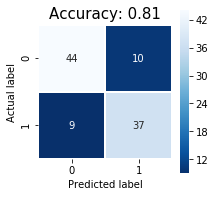

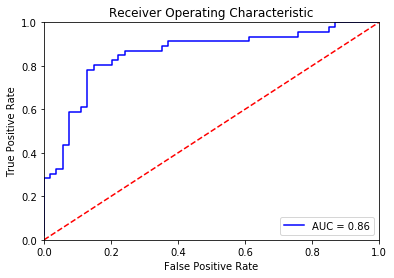

In [42]:
model_report("Original Test Set Report", test_labels, ORIG_results, ORIG_proba[:,1])